---
# Assigment 1

Name: DUONG SON THONG

Student Number: 223593948

Email: s223593948@deakin.edu.au

Postgraduate (SIT744)

---

## Introduction

Data link: https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes


The Diabetes Prediction Dataset is a useful resource for researchers, data scientists, and healthcare professionals working on diabetes risk prediction. It contains a range of important health-related features that were carefully collected to support the development of deep learning models. These models can help identify individuals who may be at risk of developing diabetes, supporting efforts in early detection and more effective treatment planning.

# Describe the dataset

This dataset comprises medical diagnostic measurements for **2,768 samples**, primarily used for predictive modeling of diabetes. It contains **10 columns**, each representing patient attributes or outcomes related to diabetes diagnostics.

**Variables**

| Variable Name | Label                             |
|---------------------|-------------------------------------------------|
| Pregnancies         | Number of times the individual has been pregnant|
| Glucose             | Plasma glucose concentration (mg/dL)            |
| BloodPressure       | Diastolic blood pressure (mm Hg)                |
| SkinThickness       | Triceps skinfold thickness (mm)                 |
| Insulin             | 2-Hour serum insulin (mu U/ml).                 |
| BMI                 | Body mass index (weight in kg/(height in m)^2)  |
| DiabetesPedigreeFunction      | A function representing diabetes likelihood based on family history          |
| Age                 | Age of the individual (years)  |
| Outcome                 | Binary indicator of diabetes presence (1 = diabetic, 0 = non-diabetic)  |
| Id                 | Unique identifier for each record.  |

**Import package**

In [22]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch.utils.tensorboard import SummaryWriter
import time
import matplotlib.pyplot as plt
import seaborn as sns


## **Set 1 Build a Simple Neural Network (P-Level Tasks)**

### **1. Define the Machine Learning Problem**

**Problem Title:** *Predicting Diabetes Diagnosis Using Neural Networks*

#### a. Problem Description

This project uses a dataset containing medical diagnostic measurements from female patients to predict the presence of diabetes. The task is a **binary classification** problem, where the goal is to determine whether a patient has diabetes (Outcome = 1) or not (Outcome = 0) based on various features such as glucose level, BMI, age, and more. Neural networks are well-suited for this task due to their ability to model complex, nonlinear relationships between health indicators.

#### b. Objectives

* Develop a neural network that can accurately classify whether a patient has diabetes.
* Evaluate model performance using appropriate metrics.
* Explore hyperparameter tuning and architecture optimization to improve model performance.

#### c. Potential Ethical Concerns and Dataset Biases

* **Dataset Bias – Gender Limitation:**
  The dataset contains only female patients, which introduces **gender bias**. As a result, the trained model may not generalize well to male patients or populations with different demographics.

* **Privacy and Security:**
  Since the dataset involves sensitive medical information, it is essential to **ensure patient anonymity** and comply with privacy laws such as **HIPAA** (Health Insurance Portability and Accountability Act) or **GDPR** (General Data Protection Regulation). Any data handling or sharing should prioritize ethical standards for data protection.

* **Model Explainability:**
  Neural networks are often considered **black-box** models. This lack of transparency can be a barrier in clinical environments where interpretability is critical. Incorporating **explainable AI (XAI)** techniques, such as SHAP or LIME, may improve trust and usability among healthcare professionals.



### **2. Dataset Selection and Justification**

#### Selected Dataset
The dataset consists of medical information from **2,768 patients**, including features like **glucose level**, **blood pressure**, **BMI**, and a binary **Outcome** indicating the presence (`1`) or absence (`0`) of diabetes.


#### Justification of Suitability

- **Size:**  
  With 2,768 entries, the dataset is reasonably sized for training a neural network without requiring excessive computational resources. While not "big data," it offers a solid foundation for supervised learning.

- **Complexity:**  
  The dataset includes a mix of **demographic** (e.g., age, pregnancies) and **physiological** (e.g., glucose, insulin) features. This complexity is well-suited for neural networks, which can model nonlinear interactions between variables.

- **Relevance:**  
  All features are medically relevant to diabetes prediction, aligning well with the classification objective.


#### Bias Considerations

- **Zero values in medical fields** (e.g., Insulin, Glucose, BloodPressure) likely indicate missing or unrecorded data, which can introduce bias if not handled properly.

- **Demographic scope is unclear**, as there is no gender or ethnicity column. This makes it hard to assess generalizability across populations.


#### Process Data

In [12]:
datasetCsv = pd.read_csv('dataset.csv')
datasetCsv.head()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


##### Process Data Steps:
- Drop the Id column (not predictive).

- Replace zero values in physiological fields with NaN.

- Impute missing values using median (robust against outliers).

- Normalize numerical features (neural networks benefit from scaled inputs).

- Separate features and labels

In [ ]:
# drop id column because it can't be a feature to train
datasetCsv.drop(columns=["Id"], axis= 1, inplace=True)
#replace zeros with NaN 
fields_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in fields_with_invalid_zeros:
    datasetCsv[col] = datasetCsv[col].apply(lambda x: np.nan if x == 0 else x)

#impute values
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(datasetCsv), columns=datasetCsv.columns)

#normalize feature columns (excluding the target)
X = df_imputed.drop(columns=['Outcome'])
y = df_imputed['Outcome']
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#combine features and label into one DataFrame

preprocessed_df = X_scaled.copy()
preprocessed_df['Outcome'] = y

preprocessed_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.679232,0.856993,-0.032190,0.641606,-0.177015,0.141662,0.478509,1.432495,1.0
1,-0.825341,-1.208717,-0.532758,-0.022803,-0.177015,-0.843952,-0.369130,-0.181079,0.0
2,1.281062,2.004610,-0.699614,-0.022803,-0.177015,-1.308598,0.616712,-0.096154,1.0
3,-0.825341,-1.077561,-0.532758,-0.687212,-0.563148,-0.632749,-0.934224,-1.030329,0.0
4,-1.126256,0.496313,-2.701886,0.641606,0.329784,1.479279,5.579704,-0.011229,1.0


##### Visualize data

### 3. Define a simple fully connected neural network using PyTorch.

### Network Architecture

- **Input Layer:**
  - Accepts a feature vector of size **8**
  - Represents input variables such as glucose, blood pressure, BMI, etc.

- **Hidden Layer:**
  - Fully connected (`Linear`) layer with **32 neurons**
  - Activation function: **ReLU** (Rectified Linear Unit)
  - ReLU introduces non-linearity to learn complex feature relationships

- **Output Layer:**
  - A single neuron (`Linear(32, 1)`)
  - **Sigmoid activation** converts output to a probability between 0 and 1

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### 4. Implement the training pipeline. Train the model and evaluate its performance on test data.

In [16]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
writer = SummaryWriter(log_dir=f"runs/experiment_initial")
class CustomDataset(Dataset):
    def __init__(self, dataFrane):
        self.data = dataFrane
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = torch.tensor(row[:-1].values, dtype=torch.float32)
        label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]
        return features, label

def train(dataLoader, model, loss_fn, optimizer, epoch, writer):
        size = len(dataLoader.dataset)
        model.train() #set model to the training mode, it just switches internal setting
        running_loss = 0.0
        correct = 0
        for batch, (X, y) in enumerate(dataLoader):
            X, y = X.to(device), y.to(device)
            predict = model(X)
            loss = loss_fn(predict, y)
            #backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() #?
            # Calculate accuracy for this batch
            pred_binary = (predict >= 0.5).float()
            correct += (pred_binary == y).sum().item()
            running_loss += loss.item()
            
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # Log training metrics to TensorBoard
        avg_loss = running_loss / len(dataLoader)
        accuracy = (correct / size) * 100
        
        writer.add_scalar('Loss/Train', avg_loss, epoch)
        writer.add_scalar('Accuracy/Train', accuracy, epoch)
                
def test(dataloader, model, loss_fn, epoch, writer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = pred.flatten()
            y = y.flatten()
            for i in range(len(pred)):
                predict = 1 if pred[i] >= 0.5 else 0
                if predict == y[i]:
                   correct += 1 
    test_loss /= num_batches
    correct /= size
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', correct, epoch)
    print(f"Accuracy: {correct}%, Avg loss: {test_loss:>8f} \n")
    return correct
    
    
customDataset = CustomDataset(preprocessed_df)

trainData, testData = random_split(customDataset, [0.8, 0.2])
print(len(trainData))
print(len(testData))
trainDataLoader = DataLoader(trainData, batch_size=64, shuffle=True)
testDataLoader = DataLoader(testData, batch_size=64, shuffle=False)
model = NeuralNetwork().to(device)
loss_fn = nn.BCELoss() # use binary cross entropy because we have 2 classes in target
optimizer = torch.optim.SGD(model.parameters(), lr= 0.1) #??? changed SGD to adam

epochs = 20
for i in range(epochs):
    print(f'Epoch {i + 1}')
    train(trainDataLoader, model, loss_fn, optimizer, i, writer)
    test(testDataLoader, model, loss_fn, i, writer)
writer.close()
print("DONE!")

2215
553
Epoch 1
loss: 0.693796  [   64/ 2215]


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_51638/3111156567.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.6636528028933092%, Avg loss: 0.553595 

Epoch 2
loss: 0.576287  [   64/ 2215]
Accuracy: 0.7305605786618445%, Avg loss: 0.501882 

Epoch 3
loss: 0.501507  [   64/ 2215]
Accuracy: 0.7649186256781193%, Avg loss: 0.470947 

Epoch 4
loss: 0.484438  [   64/ 2215]
Accuracy: 0.779385171790235%, Avg loss: 0.454889 

Epoch 5
loss: 0.471513  [   64/ 2215]
Accuracy: 0.7920433996383364%, Avg loss: 0.446529 

Epoch 6
loss: 0.464394  [   64/ 2215]
Accuracy: 0.7956600361663653%, Avg loss: 0.437688 

Epoch 7
loss: 0.405259  [   64/ 2215]
Accuracy: 0.7920433996383364%, Avg loss: 0.436097 

Epoch 8
loss: 0.347537  [   64/ 2215]
Accuracy: 0.7974683544303798%, Avg loss: 0.429454 

Epoch 9
loss: 0.340461  [   64/ 2215]
Accuracy: 0.7956600361663653%, Avg loss: 0.427460 

Epoch 10
loss: 0.385285  [   64/ 2215]
Accuracy: 0.7992766726943942%, Avg loss: 0.425543 

Epoch 11
loss: 0.310904  [   64/ 2215]
Accuracy: 0.7992766726943942%, Avg loss: 0.424845 

Epoch 12
loss: 0.319678  [   64/ 2215]
Accuracy

---

## **Set 2: Improve Model Performance (C-Level Tasks)**

### 1. Use TensorBoard to log loss and accuracy.

In [17]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 51687), started 0:00:58 ago. (Use '!kill 51687' to kill it.)

### 2. Modify the network architecture to improve performance.

- Change optimizer from SGD to Adam

In [18]:
writer = SummaryWriter(log_dir=f"runs/experiment_adam")
trainDataLoader = DataLoader(trainData, batch_size = 64, shuffle=True)
testDataLoader = DataLoader(testData, batch_size = 64, shuffle=False)
model = NeuralNetwork().to(device)
loss_fn = nn.BCELoss() # use binary cross entropy because we have 2 classes in target
optimizer = torch.optim.Adam(model.parameters(), lr= 0.1) #??? changed SGD to adam

epochs = 50
for i in range(epochs):
    print(f'Epoch {i + 1}')
    train(trainDataLoader, model, loss_fn, optimizer, i, writer)
    test(testDataLoader, model, loss_fn, i, writer)
writer.close()
print("DONE!")

Epoch 1
loss: 0.745286  [   64/ 2215]


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_51638/3111156567.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.7576853526220615%, Avg loss: 0.483718 

Epoch 2
loss: 0.472915  [   64/ 2215]
Accuracy: 0.7721518987341772%, Avg loss: 0.460722 

Epoch 3
loss: 0.331883  [   64/ 2215]
Accuracy: 0.7938517179023508%, Avg loss: 0.440362 

Epoch 4
loss: 0.468411  [   64/ 2215]
Accuracy: 0.8119349005424955%, Avg loss: 0.421055 

Epoch 5
loss: 0.360702  [   64/ 2215]
Accuracy: 0.8083182640144665%, Avg loss: 0.433909 

Epoch 6
loss: 0.330698  [   64/ 2215]
Accuracy: 0.8010849909584087%, Avg loss: 0.439091 

Epoch 7
loss: 0.394896  [   64/ 2215]
Accuracy: 0.8191681735985533%, Avg loss: 0.429997 

Epoch 8
loss: 0.288597  [   64/ 2215]
Accuracy: 0.8191681735985533%, Avg loss: 0.460966 

Epoch 9
loss: 0.378674  [   64/ 2215]
Accuracy: 0.783001808318264%, Avg loss: 0.489649 

Epoch 10
loss: 0.488841  [   64/ 2215]
Accuracy: 0.840867992766727%, Avg loss: 0.437708 

Epoch 11
loss: 0.319244  [   64/ 2215]
Accuracy: 0.759493670886076%, Avg loss: 0.531019 

Epoch 12
loss: 0.387221  [   64/ 2215]
Accuracy: 

### 3. Apply machine learning principles to adjust training configurations (e.g., learning rate, batch size).
- Reduce the learning rate from 0.1 to 0.01
- Reduce batch_size from 64 to 32

In [19]:
writer = SummaryWriter(log_dir=f"runs/experiment_rl_batch")
trainDataLoader = DataLoader(trainData, batch_size = 32, shuffle=True)
testDataLoader = DataLoader(testData, batch_size = 32, shuffle=False)
model = NeuralNetwork().to(device)
loss_fn = nn.BCELoss() # use binary cross entropy because we have 2 classes in target
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01) #??? changed SGD to adam

epochs = 50
for i in range(epochs):
    print(f'Epoch {i + 1}')
    train(trainDataLoader, model, loss_fn, optimizer, i, writer)
    test(testDataLoader, model, loss_fn, i, writer)
writer.close()
print("DONE!")

Epoch 1
loss: 0.671316  [   32/ 2215]


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_51638/3111156567.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.7504520795660036%, Avg loss: 0.464867 

Epoch 2
loss: 0.490797  [   32/ 2215]
Accuracy: 0.7902350813743219%, Avg loss: 0.429563 

Epoch 3
loss: 0.469935  [   32/ 2215]
Accuracy: 0.7920433996383364%, Avg loss: 0.427358 

Epoch 4
loss: 0.385399  [   32/ 2215]
Accuracy: 0.8227848101265823%, Avg loss: 0.415010 

Epoch 5
loss: 0.527166  [   32/ 2215]
Accuracy: 0.8155515370705244%, Avg loss: 0.411663 

Epoch 6
loss: 0.391215  [   32/ 2215]
Accuracy: 0.8028933092224232%, Avg loss: 0.416732 

Epoch 7
loss: 0.373379  [   32/ 2215]
Accuracy: 0.833634719710669%, Avg loss: 0.404513 

Epoch 8
loss: 0.188931  [   32/ 2215]
Accuracy: 0.8119349005424955%, Avg loss: 0.417727 

Epoch 9
loss: 0.324218  [   32/ 2215]
Accuracy: 0.8083182640144665%, Avg loss: 0.415533 

Epoch 10
loss: 0.353309  [   32/ 2215]
Accuracy: 0.8191681735985533%, Avg loss: 0.423961 

Epoch 11
loss: 0.399039  [   32/ 2215]
Accuracy: 0.8227848101265823%, Avg loss: 0.427424 

Epoch 12
loss: 0.516646  [   32/ 2215]
Accuracy

### 4. Analyse model training using TensorBoard and compare different runs.

In [20]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 51687), started 0:01:30 ago. (Use '!kill 51687' to kill it.)

Using TensorBoard, we compared three different training configurations:

- **Gray line**
  - `optimizer = SGD`, `lr = 0.1`, `batch_size = 64`, `epochs = 20`
  - **Lowest performance**, final accuracy around 78–79%
  - High learning rate with SGD caused instability; fewer epochs limited learning

- **Blue line**
  - `optimizer = Adam`, `lr = 0.1`, `batch_size = 64`, `epochs = 50`
  - Moderate performance, accuracy plateaued early at ~85%
  - Learning rate of 0.1 is **too aggressive** for Adam, causing suboptimal convergence

- **Red line**
  - `optimizer = Adam`, `lr = 0.01`, `batch_size = 32`, `epochs = 50`
  - **Best performance**, reaching ~89% accuracy
  - Stable training curve with consistent improvements
  - Smaller batch size and lower learning rate helped generalization and stability

### 5. Justify Design Choices Based on Practical Outcomes

Based on the TensorBoard results:

- **Adam** is preferred over SGD for its adaptive learning and faster convergence
- A **lower learning rate (0.01)** ensures stability and smoother optimization
- **Smaller batch size (32)** improves gradient diversity and generalization
- **Training longer (50 epochs)** allows the model to learn more effectively



---

## **Set 3 Ethical Analysis and Model Evaluation (D-Level Tasks)**

### 1. Analyze dataset biases programmatically by visualising class distributions and measuring imbalances. Assess how these biases impact model performance.



#### Visualizing Class Distribution

/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_51638/480426488.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_counts.index.astype(str), y=outcome_counts.values, palette='pastel')


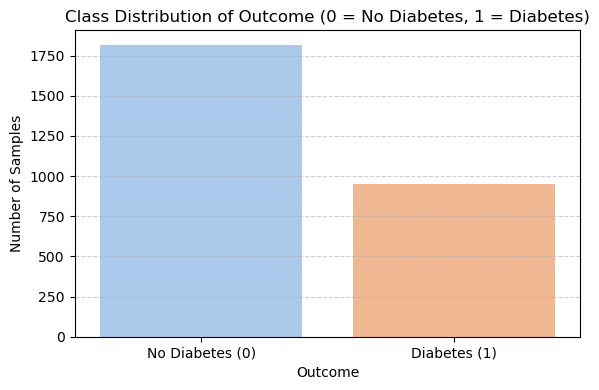

In [27]:
outcome_counts = df_imputed['Outcome'].value_counts().sort_index()

# Bar chart for imbalance
plt.figure(figsize=(6, 4))
sns.barplot(x=outcome_counts.index.astype(str), y=outcome_counts.values, palette='pastel')
plt.title("Class Distribution of Outcome (0 = No Diabetes, 1 = Diabetes)")
plt.xlabel("Outcome")
plt.ylabel("Number of Samples")
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



The bar chart above shows the distribution of the `Outcome` variable (0 = No Diabetes, 1 = Diabetes):

- Class 0 (No Diabetes): ~1,800 samples  
- Class 1 (Diabetes): ~960 samples  

This indicates a moderate class imbalance, with the majority class making up about **65%** of the data.

---

#### Bias Assessment and Impact on Model Performance

**A. Class Imbalance**

- The dataset is not balanced, and this affects the ability of the model to generalize.
- A naive classifier could achieve ~65% accuracy by always predicting the majority class (`0`).
- This leads to poor recall and F1-score for the minority class (`1`), which is critical in medical diagnosis tasks.

**B. Real-World Implications**

- The model becomes biased toward predicting 'No Diabetes'.
- It may fail to detect true diabetic cases, leading to false negatives.
- In real-world applications like healthcare, this kind of bias can result in serious consequences.

---

#### Mitigation Strategies

To reduce the negative effects of this imbalance:

1. Oversampling the minority class, e.g., using **SMOTE**.
2. Using class weights in the loss function, such as `BCEWithLogitsLoss(pos_weight=...)`.
3. Evaluating with metrics like precision, recall, and F1-score rather than just accuracy.

---



### 2. Experiment with mitigation techniques, such as rebalancing the dataset, modifying loss functions, or applying bias correction strategies. Compare results.

In [23]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

preprocessed_df = pd.DataFrame(X_resampled, columns=X.columns)
preprocessed_df['Outcome'] = y_resampled


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_51638/3792209195.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_counts.index.astype(str), y=outcome_counts.values, palette='pastel')


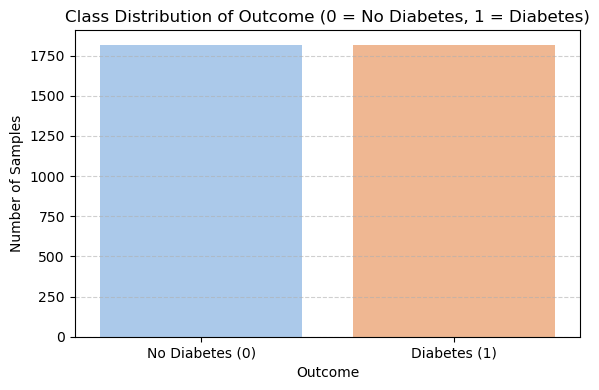

In [26]:
outcome_counts = preprocessed_df['Outcome'].value_counts().sort_index()

# Bar chart for imbalance
plt.figure(figsize=(6, 4))
sns.barplot(x=outcome_counts.index.astype(str), y=outcome_counts.values, palette='pastel')
plt.title("Class Distribution of Outcome (0 = No Diabetes, 1 = Diabetes)")
plt.xlabel("Outcome")
plt.ylabel("Number of Samples")
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [28]:
customDataset = CustomDataset(preprocessed_df)

trainData, testData = random_split(customDataset, [0.8, 0.2])

writer = SummaryWriter(log_dir=f"runs/experiment_blance_data")
trainDataLoader = DataLoader(trainData, batch_size = 32, shuffle=True)
testDataLoader = DataLoader(testData, batch_size = 32, shuffle=False)
model = NeuralNetwork().to(device)
loss_fn = nn.BCELoss() # use binary cross entropy because we have 2 classes in target
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01) #??? changed SGD to adam

epochs = 50
for i in range(epochs):
    print(f'Epoch {i + 1}')
    train(trainDataLoader, model, loss_fn, optimizer, i, writer)
    test(testDataLoader, model, loss_fn, i, writer)
writer.close()
print("DONE!")

Epoch 1
loss: 0.682525  [   32/ 2906]


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_51638/3111156567.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.7947658402203857%, Avg loss: 0.470565 

Epoch 2
loss: 0.442249  [   32/ 2906]
Accuracy: 0.7892561983471075%, Avg loss: 0.439477 

Epoch 3
loss: 0.597463  [   32/ 2906]
Accuracy: 0.8085399449035813%, Avg loss: 0.434183 

Epoch 4
loss: 0.602100  [   32/ 2906]
Accuracy: 0.8057851239669421%, Avg loss: 0.424722 

Epoch 5
loss: 0.483425  [   32/ 2906]
Accuracy: 0.7933884297520661%, Avg loss: 0.422730 

Epoch 6
loss: 0.493439  [   32/ 2906]
Accuracy: 0.8099173553719008%, Avg loss: 0.419499 

Epoch 7
loss: 0.247072  [   32/ 2906]
Accuracy: 0.8016528925619835%, Avg loss: 0.416254 

Epoch 8
loss: 0.508715  [   32/ 2906]
Accuracy: 0.8140495867768595%, Avg loss: 0.418881 

Epoch 9
loss: 0.315423  [   32/ 2906]
Accuracy: 0.8085399449035813%, Avg loss: 0.423778 

Epoch 10
loss: 0.453352  [   32/ 2906]
Accuracy: 0.8154269972451791%, Avg loss: 0.410522 

Epoch 11
loss: 0.612444  [   32/ 2906]
Accuracy: 0.8154269972451791%, Avg loss: 0.415068 

Epoch 12
loss: 0.312444  [   32/ 2906]
Accurac

In [29]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 51687), started 2:09:26 ago. (Use '!kill 51687' to kill it.)

### Reference
Deakin University, 2025. Data Wrangling Unit (SIT731) [Module 3 - Data Validation]. Deakin University.

PyTorch, 2025. PyTorch Documentation. Available at: https://docs.pytorch.org/ [Accessed 22 July 2025].
